# Set-up

In [ ]:
import sys
!{sys.executable} -m pip install 'git+https://github.com/gaetanochiriaco/food-recognition'

In [2]:
# functions and modules from github repo
from food_recognition.dataloader import load_data
from food_recognition.cam.utils.plots import plot_image,plot_bbox_on_image
from food_recognition.cam.utils.reshape_transforms import swin_reshape_transform
from food_recognition.cam.get_cam import get_output_and_cam
from food_recognition.cam.utils.image import return_bbox
from food_recognition.cam.utils.image import get_cam_on_image
from food_recognition.cam.utils.image import from_tensor_to_image

In [3]:
# other functions and modules
import pandas as pd
import zipfile
import os
import timm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [4]:
# connection to gdrive folder to import data/checkpoints
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# Data loading

In [5]:
# Loading labels
if not os.path.exists("/content/Food2k_label"):
  with zipfile.ZipFile('/content/drive/MyDrive/TesiMagistrale/data/Food2k_label.zip', "r") as z:
    z.extractall("/content/")

In [6]:
# extracting data on disk
!tar -xf /content/drive/MyDrive/TesiMagistrale/data/Food2k_resize.tar -C /content

In [7]:
# loading dataset in batches
train_dataset, train_loader, test_dataset, test_loader = load_data(
    image_path= "/content/Food2k_resize",
    train_dir = "/content/Food2k_label/train_finetune.txt" ,
    test_dir = "/content/Food2k_label/test_finetune.txt",
    batch_size= 16
)

In [8]:
# use only one batch for next examples
for x,y in test_loader:
  batch_tensor = x
  break

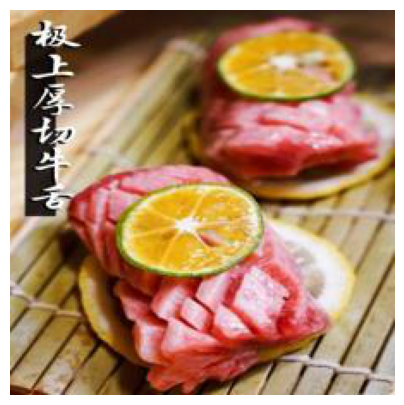

In [9]:
# Printing the first image in the selected batch
plot_image(batch_tensor,num_element=0)

# Model loading

In [ ]:
# base model architecture from huggingface
model = timm.create_model('swin_base_patch4_window7_224_in22k', pretrained=False, num_classes = 2000)

In [11]:
# loading my pre-trained weights on Food2k 
checkpoint = torch.load("/content/drive/MyDrive/TesiMagistrale/VIT/checkpoints/swin_base_finetune.pt")
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda()

# Extract and Visualize CAM from Swin Transformer

In [12]:
# chosen target layer 
target_layer = [model.layers[-1].blocks[-1].norm1]

# get class prediction and class activation map for each element in batch
out,cam = get_output_and_cam(model = model,
                             target_layer = target_layer,
                             reshape_transform = swin_reshape_transform,
                             input_tensor = batch_tensor)


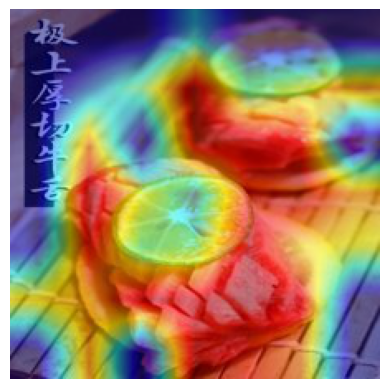

In [16]:
# Showing the class activation map on the original image
plt.imshow(get_cam_on_image(batch_tensor,cam[0],use_rgb=True))
plt.axis('off')
plt.show()

<Figure size 500x500 with 0 Axes>

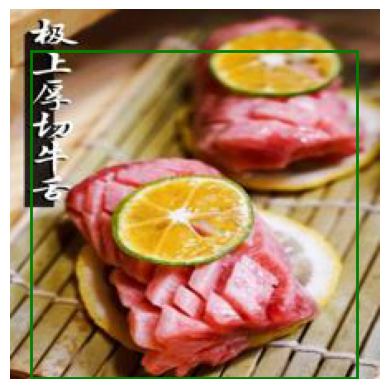

In [18]:
# Calculating and visualizing a candidate bounding box
bbox = return_bbox(cam[[0],:,:],ratio = 0.5)
plot_bbox_on_image(batch_tensor,bbox)
plt.show()